# Starbucks Promotion Analysis

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer **accumulates at least 10 dollars** in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. **You'll want to try to assess what a certain demographic group will buy when not receiving any offers.**

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example

(1) You could build a machine learning model that predicts how much someone will spend based on demographics and offer type.  
  
(2) You could build a model that predicts whether or not someone will respond to an offer.   
  
(3) You could develop a set of heuristics that determine what offer you should send to each customer. (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Overview  of this notebook

1. Load in files
2. Clean the data
3. Univariate Exploration
4. 

# 1. Load in files

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import time
% matplotlib inline

# read in the json files
portfolio = pd.read_csv('data/portfolio_clean.csv', )
profile = pd.read_csv('data/profile_clean.csv')
transcript = pd.read_csv('data/transcript_clean.csv')
interaction = pd.read_csv('data/interaction.csv')

pd.options.display.max_rows = 100
pd.set_option("display.max_columns", 500)

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"['email', 'mobile', 'social']",10,7,bogo_7days$10,bogo,10
1,"['web', 'email', 'mobile', 'social']",10,5,bogo_5days$10,bogo,10
2,"['web', 'email', 'mobile']",0,4,info_4days,informational,0
3,"['web', 'email', 'mobile']",5,7,bogo_7days$5,bogo,5
4,"['web', 'email']",20,10,disc_10days$20-$5,discount,5


In [3]:
profile.head()

,age,became_member_on,id,income,gender_F,gender_M,gender_O
0,NaN,2017-02-12,68be06ca386d4c31939f3a4f0e3dd783,NaN,NaN,NaN,NaN
1,55.0,2017-07-15,0610b486422d4921ae7d2bf64640c50b,112000.0,1.0,0.0,0.0
2,NaN,2018-07-12,38fe809add3b4fcf9315a9694bb96ff5,NaN,NaN,NaN,NaN
3,75.0,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1.0,0.0,0.0
4,NaN,2017-08-04,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,NaN,NaN


In [4]:
transcript.head()

,event,person,time,transaction,id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,bogo_7days$5
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,disc_10days$20-$5
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,disc_7days$10-$2
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,disc_10days$10-$2
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,bogo_5days$10


In [5]:
interaction.head()

,person,age,income,gender_F,gender_M,gender_O,became_year,became_month_sin,became_month_cos,became_day_sin,became_day_cos,became_dow_sin,became_dow_cos,offer_bogo,offer_disc,difficulty,duration,reward,email,mobile,social,web,t_received,t_viewed,amt_till_viewed,t_completed,amt_till_completed
0,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,1.0,0.0,0.0,2017,0.500000,-8.660254e-01,0.968077,-0.250653,0.781831,0.623490,1,0,5,7,5,1,1,0,1,0,6.0,0.0,132.0,19.89
1,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,NaN,NaN,NaN,2017,-0.866025,-5.000000e-01,0.724793,0.688967,-0.433884,-0.900969,0,1,20,10,5,1,0,0,1,0,6.0,0.0,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,68.0,70000.0,0.0,1.0,0.0,2018,0.866025,-5.000000e-01,-0.848644,0.528964,0.433884,-0.900969,0,1,10,7,2,1,1,0,1,0,18.0,0.0,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,NaN,NaN,NaN,NaN,2017,-1.000000,-1.836970e-16,-0.937752,0.347305,0.000000,1.000000,0,1,10,10,2,1,1,1,1,0,12.0,0.0,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,NaN,NaN,NaN,NaN,NaN,2017,-0.866025,5.000000e-01,0.394356,0.918958,0.000000,1.000000,1,0,10,5,10,1,1,1,1,0,84.0,0.0,NaN,NaN


In [288]:
offer_viewed = pd.read_csv("data/firstly_viewed_offers.csv")
print(offer_viewed.shape)
offer_viewed.head()

(32007, 27)


,person,age,income,gender_F,gender_M,gender_O,became_year,became_month_sin,became_month_cos,became_day_sin,became_day_cos,became_dow_sin,became_dow_cos,offer_bogo,offer_disc,difficulty,duration,reward,email,mobile,social,web,t_received,t_viewed,amt_till_viewed,t_completed,amt_till_completed
0,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,1.0,0.0,0.0,2017,5.000000e-01,-8.660254e-01,9.680771e-01,-0.250653,0.781831,0.623490,1,0,5,7,5,1,1,0,1,0,6.0,0.00,132.0,19.89
1,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,NaN,NaN,NaN,2017,-8.660254e-01,-5.000000e-01,7.247928e-01,0.688967,-0.433884,-0.900969,0,1,20,10,5,1,0,0,1,0,6.0,0.00,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,68.0,70000.0,0.0,1.0,0.0,2018,8.660254e-01,-5.000000e-01,-8.486443e-01,0.528964,0.433884,-0.900969,0,1,10,7,2,1,1,0,1,0,18.0,0.00,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,NaN,NaN,NaN,NaN,2017,-1.000000e+00,-1.836970e-16,-9.377521e-01,0.347305,0.000000,1.000000,0,1,10,10,2,1,1,1,1,0,12.0,0.00,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,NaN,NaN,NaN,NaN,NaN,2017,-8.660254e-01,5.000000e-01,3.943559e-01,0.918958,0.000000,1.000000,1,0,10,5,10,1,1,1,1,0,84.0,0.00,NaN,NaN
5,389bc3fa690240e798340f5a15918d5c,65.0,53000.0,0.0,1.0,0.0,2018,8.660254e-01,5.000000e-01,9.680771e-01,-0.250653,-0.433884,-0.900969,1,0,5,5,5,1,1,1,1,0,0.0,0.00,60.0,9.54
6,c4863c7985cf408faee930f111475da3,NaN,NaN,NaN,NaN,NaN,2017,-8.660254e-01,-5.000000e-01,-9.884683e-01,0.151428,0.433884,-0.900969,0,1,7,7,3,1,1,1,1,0,24.0,0.00,NaN,NaN
7,aa4862eba776480b8bb9c68455b8c2e1,61.0,57000.0,1.0,0.0,0.0,2017,-1.000000e+00,-1.836970e-16,7.907757e-01,-0.612106,0.000000,1.000000,0,1,20,10,5,1,0,0,1,0,18.0,0.00,NaN,NaN
8,31dda685af34476cad5bc968bdb01c53,62.0,71000.0,1.0,0.0,0.0,2016,8.660254e-01,5.000000e-01,7.907757e-01,-0.612106,0.433884,-0.900969,0,1,20,10,5,1,0,0,1,0,150.0,0.00,NaN,NaN
9,744d603ef08c4f33af5a61c8c7628d1c,NaN,NaN,NaN,NaN,NaN,2017,-8.660254e-01,-5.000000e-01,2.012985e-01,0.979530,0.781831,0.623490,0,1,20,10,5,1,0,0,1,0,48.0,0.00,NaN,NaN


In [289]:
# remove offers whose receivers has null values in his attributes
offer_viewed_no_null = offer_viewed[offer_viewed.isnull().iloc[:,:10].sum(axis = 1) == 0]

In [290]:
print(offer_viewed_no_null.shape)
offer_viewed_no_null.groupby("person")["offer_bogo"].count().value_counts().sort_index()

(26971, 27)


1    4328
2    5032
3    2844
4     873
5     111
Name: offer_bogo, dtype: int64

### I will make a model which predicts whether [a custmer who had offers more than 3 offers] would see the next offer or not.

In [291]:
customers_for_model = offer_viewed_no_null.groupby("person")["offer_bogo"].count().index[offer_viewed_no_null.groupby("person")["offer_bogo"].count() >= 3]
customers_for_model

Index(['0011e0d4e6b944f998e987f904e8c1e5', '0020ccbbb6d84e358d3414a3ff76cffd',
       '004c5799adbf42868b9cff0396190900', '00857b24b13f4fe0ad17b605f00357f5',
       '008d7088107b468893889da0ede0df5c', '0099bf30e4cb4265875266eb3eb25eab',
       '00ae03011f9f49b8a4b3e6d416678b0b', '00b18b535d6d4f779dea4dc9ac451478',
       '00b901d68f8f4fd68075184cd0f772d2', '00bc42a62f884b41a13cc595856cf7c3',
       ...
       'ff48bf4b65cf41a29d7086e3f742a73e', 'ff56a64e9a0e4bf5919723f31bce5965',
       'ff5d261ea11c46e4af8f85ea2cf35b61', 'ff7cc9b97c7744cfbc31bb020ea8d07e',
       'ff7fdf82996949ec82d158a02a1d9cca', 'ff8bb9517a1e4ef18b63eb9f2ba67d9e',
       'ff932c6f8bb641bd816955337d153676', 'ff992fbec53145bbae59a68d025e0458',
       'fff7576017104bcc8677a8d63322b5e1', 'ffff82501cea40309d5fdd7edcca4a07'],
      dtype='object', name='person', length=3828)

In [292]:
offer_viewed_no_null_3or_more = offer_viewed_no_null[offer_viewed_no_null.person.isin(customers_for_model)]
offer_viewed_no_null_3or_more.shape

(12579, 27)

In [293]:
offer_person_time = offer_viewed_no_null_3or_more.groupby("person").max()["t_received"]
offer_person_time.shape, offer_person_time.head()

((3828,), person
 0011e0d4e6b944f998e987f904e8c1e5    504
 0020ccbbb6d84e358d3414a3ff76cffd    504
 004c5799adbf42868b9cff0396190900    504
 00857b24b13f4fe0ad17b605f00357f5    504
 008d7088107b468893889da0ede0df5c    504
 Name: t_received, dtype: int64)

In [294]:
# Boolean mask which indicates whether the row is the last offer for the person
last_mask = (offer_viewed_no_null_3or_more["person"] + offer_viewed_no_null_3or_more["t_received"].astype(str)).isin(
        offer_person_time.index + offer_person_time.astype(str))

offer_viewed_no_null_3or_more_last = offer_viewed_no_null_3or_more[last_mask]

In [295]:
offer_viewed_no_null_3or_more_last.head()

,person,age,income,gender_F,gender_M,gender_O,became_year,became_month_sin,became_month_cos,became_day_sin,became_day_cos,became_dow_sin,became_dow_cos,offer_bogo,offer_disc,difficulty,duration,reward,email,mobile,social,web,t_received,t_viewed,amt_till_viewed,t_completed,amt_till_completed
14130,31dda685af34476cad5bc968bdb01c53,62.0,71000.0,1.0,0.0,0.0,2016,8.660254e-01,5.000000e-01,0.790776,-0.612106,0.433884,-0.900969,0,1,7,7,3,1,1,1,1,336,0.0,0.00,48.0,12.57
14136,1e9420836d554513ab90eba98552d0a9,22.0,70000.0,0.0,1.0,0.0,2017,-1.000000e+00,-1.836970e-16,-0.937752,0.347305,0.000000,1.000000,1,0,10,5,10,1,1,1,1,336,18.0,0.00,78.0,30.20
14152,99e9a1916821461ebd5d5048dc2dff7d,58.0,85000.0,1.0,0.0,0.0,2018,5.000000e-01,8.660254e-01,-0.937752,0.347305,0.433884,-0.900969,0,1,20,10,5,1,0,0,1,336,36.0,15.99,72.0,44.31
14159,9aba5058cb4f483da896335a1479a944,65.0,119000.0,1.0,0.0,0.0,2017,-1.000000e+00,-1.836970e-16,0.968077,-0.250653,-0.974928,-0.222521,1,0,5,5,5,1,1,1,1,336,18.0,0.00,42.0,29.00
14182,127cd9d95e6247e5b92bff64d6205a94,46.0,60000.0,0.0,1.0,0.0,2014,-2.449294e-16,1.000000e+00,0.299363,-0.954139,-0.781831,0.623490,0,1,10,10,2,1,1,1,1,336,30.0,3.41,48.0,15.92


# 2. Create the model.

As was written in the last notebook, the distribution of time which each customer has spent till he views the offer can be a great variable which belongs to his behavior pattern. I have to note that the distrbution should bot include the data before or the exactly that row.

# Feature Engineering1 : integrate the viewing time of the coupone

In [296]:
# extract necessary columns
t_viewed = interaction.copy()[["person", "t_received", "t_viewed"]]

In [297]:
t_viewed

,person,t_received,t_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,6.0
1,a03223e636434f42ac4c3df47e8bac43,0,6.0
2,e2127556f4f64592b11af22de27a7932,0,18.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,12.0
4,68617ca6246f4fbc85e91a2a49552598,0,84.0
5,389bc3fa690240e798340f5a15918d5c,0,0.0
6,c4863c7985cf408faee930f111475da3,0,24.0
7,aa4862eba776480b8bb9c68455b8c2e1,0,18.0
8,31dda685af34476cad5bc968bdb01c53,0,150.0
9,744d603ef08c4f33af5a61c8c7628d1c,0,48.0


In [298]:
# replace t = nan(never viewed) with 1000(arbitrary long hour : interpreted as it takes 1000 hours till he views) 
t_viewed.t_viewed = t_viewed.t_viewed.replace(np.nan,1000)

# mask of boolean which represents whether each offer was viewed until t = 120 hours
mask_over_120hour = t_viewed.t_viewed.astype(int) // 120 > 0

In [299]:
# now the offers which are not viewed until t = 120 hours are shown as 1000. 
t_viewed.loc[mask_over_120hour, "t_viewed"] = 777

t_viewed.head(10)

,person,t_received,t_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,6.0
1,a03223e636434f42ac4c3df47e8bac43,0,6.0
2,e2127556f4f64592b11af22de27a7932,0,18.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,12.0
4,68617ca6246f4fbc85e91a2a49552598,0,84.0
5,389bc3fa690240e798340f5a15918d5c,0,0.0
6,c4863c7985cf408faee930f111475da3,0,24.0
7,aa4862eba776480b8bb9c68455b8c2e1,0,18.0
8,31dda685af34476cad5bc968bdb01c53,0,777.0
9,744d603ef08c4f33af5a61c8c7628d1c,0,48.0


In [300]:
t_viewed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48326 entries, 0 to 48325
Data columns (total 3 columns):
person        48326 non-null object
t_received    48326 non-null int64
t_viewed      48326 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.1+ MB


In [301]:
index = pd.Series(t_viewed.t_viewed.unique()).sort_values()
df = pd.DataFrame(columns=index)
df["person"] = offer_viewed_no_null_3or_more_last.person
df = df.replace(np.nan, 0)
df.head()

,0.0,6.0,12.0,18.0,24.0,30.0,36.0,42.0,48.0,54.0,60.0,66.0,72.0,78.0,84.0,90.0,96.0,102.0,108.0,114.0,777.0,person
14130,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31dda685af34476cad5bc968bdb01c53
14136,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1e9420836d554513ab90eba98552d0a9
14152,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,99e9a1916821461ebd5d5048dc2dff7d
14159,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9aba5058cb4f483da896335a1479a944
14182,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,127cd9d95e6247e5b92bff64d6205a94


In [302]:
t = time.time()

person_index = []

# for each of the row which represents the last offer to each person who has got >= 3 offers...
for i, (each_person, each_time) in enumerate(zip(offer_viewed_no_null_3or_more_last.person, offer_viewed_no_null_3or_more_last.t_received)):
    
    # offers sent to that person BEFORE that last offer
    offers_before =  t_viewed[(t_viewed.person == each_person) & (t_viewed.t_received < each_time)]
    
    for t in offers_before.t_viewed:
        temp_row = df.iloc[i].copy()
        temp_row.loc[t] += 1
        df.iloc[i] = temp_row

time.time() - t

1554848536.818215

In [303]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3828 entries, 14130 to 32006
Data columns (total 22 columns):
0.0       3828 non-null int64
6.0       3828 non-null int64
12.0      3828 non-null int64
18.0      3828 non-null int64
24.0      3828 non-null int64
30.0      3828 non-null int64
36.0      3828 non-null int64
42.0      3828 non-null int64
48.0      3828 non-null int64
54.0      3828 non-null int64
60.0      3828 non-null int64
66.0      3828 non-null int64
72.0      3828 non-null int64
78.0      3828 non-null int64
84.0      3828 non-null int64
90.0      3828 non-null int64
96.0      3828 non-null int64
102.0     3828 non-null int64
108.0     3828 non-null int64
114.0     3828 non-null int64
777.0     3828 non-null int64
person    3828 non-null object
dtypes: int64(21), object(1)
memory usage: 687.8+ KB


In [304]:
df2 = df.replace(np.nan, 0)
df2.iloc[:,:-1] = df2.iloc[:,:-1].cumsum(axis=1)
df2 = df2.rename(columns = {777:"denom_viewed"})
df2.head()

,0.0,6.0,12.0,18.0,24.0,30.0,36.0,42.0,48.0,54.0,60.0,66.0,72.0,78.0,84.0,90.0,96.0,102.0,108.0,114.0,denom_viewed,person
14130,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,31dda685af34476cad5bc968bdb01c53
14136,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,1e9420836d554513ab90eba98552d0a9
14152,0,0,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,99e9a1916821461ebd5d5048dc2dff7d
14159,0,0,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,9aba5058cb4f483da896335a1479a944
14182,0,0,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,127cd9d95e6247e5b92bff64d6205a94


In [305]:
for column_name in df2.columns[:-2]:
        df2[column_name] = df2[column_name].astype(float) / df2.denom_viewed

In [306]:
df2.head()
df2.to_csv("data/hour_vs_viewed_modified", index=False)

In [307]:
interaction[interaction.person ==
        "1e9420836d554513ab90eba98552d0a9"]

,person,age,income,gender_F,gender_M,gender_O,became_year,became_month_sin,became_month_cos,became_day_sin,became_day_cos,became_dow_sin,became_dow_cos,offer_bogo,offer_disc,difficulty,duration,reward,email,mobile,social,web,t_received,t_viewed,amt_till_viewed,t_completed,amt_till_completed
17,1e9420836d554513ab90eba98552d0a9,22.0,70000.0,0.0,1.0,0.0,2017,-1.0,-1.836970e-16,-0.937752,0.347305,0.0,1.0,1,0,10,7,10,1,1,1,0,0,96.0,0.00,NaN,NaN
10129,1e9420836d554513ab90eba98552d0a9,22.0,70000.0,0.0,1.0,0.0,2017,-1.0,-1.836970e-16,-0.937752,0.347305,0.0,1.0,1,0,10,5,10,1,1,1,1,168,6.0,0.00,30.0,17.11
20258,1e9420836d554513ab90eba98552d0a9,22.0,70000.0,0.0,1.0,0.0,2017,-1.0,-1.836970e-16,-0.937752,0.347305,0.0,1.0,1,0,10,5,10,1,1,1,1,336,18.0,0.00,78.0,30.20
30439,1e9420836d554513ab90eba98552d0a9,22.0,70000.0,0.0,1.0,0.0,2017,-1.0,-1.836970e-16,-0.937752,0.347305,0.0,1.0,0,1,7,7,3,1,1,1,1,408,6.0,20.63,6.0,20.63


In [308]:
merged_df = offer_viewed_no_null_3or_more_last.merge(df2)
merged_df.head()

,person,age,income,gender_F,gender_M,gender_O,became_year,became_month_sin,became_month_cos,became_day_sin,became_day_cos,became_dow_sin,became_dow_cos,offer_bogo,offer_disc,difficulty,duration,reward,email,mobile,social,web,t_received,t_viewed,amt_till_viewed,t_completed,amt_till_completed,0.0,6.0,12.0,18.0,24.0,30.0,36.0,42.0,48.0,54.0,60.0,66.0,72.0,78.0,84.0,90.0,96.0,102.0,108.0,114.0,denom_viewed
0,31dda685af34476cad5bc968bdb01c53,62.0,71000.0,1.0,0.0,0.0,2016,8.660254e-01,5.000000e-01,0.790776,-0.612106,0.433884,-0.900969,0,1,7,7,3,1,1,1,1,336,0.0,0.00,48.0,12.57,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,2
1,1e9420836d554513ab90eba98552d0a9,22.0,70000.0,0.0,1.0,0.0,2017,-1.000000e+00,-1.836970e-16,-0.937752,0.347305,0.000000,1.000000,1,0,10,5,10,1,1,1,1,336,18.0,0.00,78.0,30.20,0.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,2
2,99e9a1916821461ebd5d5048dc2dff7d,58.0,85000.0,1.0,0.0,0.0,2018,5.000000e-01,8.660254e-01,-0.937752,0.347305,0.433884,-0.900969,0,1,20,10,5,1,0,0,1,336,36.0,15.99,72.0,44.31,0.0,0.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2
3,9aba5058cb4f483da896335a1479a944,65.0,119000.0,1.0,0.0,0.0,2017,-1.000000e+00,-1.836970e-16,0.968077,-0.250653,-0.974928,-0.222521,1,0,5,5,5,1,1,1,1,336,18.0,0.00,42.0,29.00,0.0,0.0,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2
4,127cd9d95e6247e5b92bff64d6205a94,46.0,60000.0,0.0,1.0,0.0,2014,-2.449294e-16,1.000000e+00,0.299363,-0.954139,-0.781831,0.623490,0,1,10,10,2,1,1,1,1,336,30.0,3.41,48.0,15.92,0.0,0.0,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2


In [309]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3828 entries, 14130 to 32006
Data columns (total 22 columns):
0.0             3828 non-null float64
6.0             3828 non-null float64
12.0            3828 non-null float64
18.0            3828 non-null float64
24.0            3828 non-null float64
30.0            3828 non-null float64
36.0            3828 non-null float64
42.0            3828 non-null float64
48.0            3828 non-null float64
54.0            3828 non-null float64
60.0            3828 non-null float64
66.0            3828 non-null float64
72.0            3828 non-null float64
78.0            3828 non-null float64
84.0            3828 non-null float64
90.0            3828 non-null float64
96.0            3828 non-null float64
102.0           3828 non-null float64
108.0           3828 non-null float64
114.0           3828 non-null float64
denom_viewed    3828 non-null int64
person          3828 non-null object
dtypes: float64(20), int64(1), object(1)
memory usage: 

In [310]:
merged_df.columns

Index([            'person',                'age',             'income',
                 'gender_F',           'gender_M',           'gender_O',
              'became_year',   'became_month_sin',   'became_month_cos',
           'became_day_sin',     'became_day_cos',     'became_dow_sin',
           'became_dow_cos',         'offer_bogo',         'offer_disc',
               'difficulty',           'duration',             'reward',
                    'email',             'mobile',             'social',
                      'web',         't_received',           't_viewed',
          'amt_till_viewed',        't_completed', 'amt_till_completed',
                        0.0,                  6.0,                 12.0,
                       18.0,                 24.0,                 30.0,
                       36.0,                 42.0,                 48.0,
                       54.0,                 60.0,                 66.0,
                       72.0,                 78.0, 

In [311]:
merged_df

,person,age,income,gender_F,gender_M,gender_O,became_year,became_month_sin,became_month_cos,became_day_sin,became_day_cos,became_dow_sin,became_dow_cos,offer_bogo,offer_disc,difficulty,duration,reward,email,mobile,social,web,t_received,t_viewed,amt_till_viewed,t_completed,amt_till_completed,0.0,6.0,12.0,18.0,24.0,30.0,36.0,42.0,48.0,54.0,60.0,66.0,72.0,78.0,84.0,90.0,96.0,102.0,108.0,114.0,denom_viewed
0,31dda685af34476cad5bc968bdb01c53,62.0,71000.0,1.0,0.0,0.0,2016,8.660254e-01,5.000000e-01,7.907757e-01,-0.612106,0.433884,-0.900969,0,1,7,7,3,1,1,1,1,336,0.0,0.00,48.0,12.57,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,2
1,1e9420836d554513ab90eba98552d0a9,22.0,70000.0,0.0,1.0,0.0,2017,-1.000000e+00,-1.836970e-16,-9.377521e-01,0.347305,0.000000,1.000000,1,0,10,5,10,1,1,1,1,336,18.0,0.00,78.0,30.20,0.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1.000000,1.000000,1.000000,1.000000,2
2,99e9a1916821461ebd5d5048dc2dff7d,58.0,85000.0,1.0,0.0,0.0,2018,5.000000e-01,8.660254e-01,-9.377521e-01,0.347305,0.433884,-0.900969,0,1,20,10,5,1,0,0,1,336,36.0,15.99,72.0,44.31,0.000000,0.000000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2
3,9aba5058cb4f483da896335a1479a944,65.0,119000.0,1.0,0.0,0.0,2017,-1.000000e+00,-1.836970e-16,9.680771e-01,-0.250653,-0.974928,-0.222521,1,0,5,5,5,1,1,1,1,336,18.0,0.00,42.0,29.00,0.000000,0.000000,0.500000,0.500000,0.500000,0.500000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2
4,127cd9d95e6247e5b92bff64d6205a94,46.0,60000.0,0.0,1.0,0.0,2014,-2.449294e-16,1.000000e+00,2.993631e-01,-0.954139,-0.781831,0.623490,0,1,10,10,2,1,1,1,1,336,30.0,3.41,48.0,15.92,0.000000,0.000000,0.500000,0.500000,0.500000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2
5,031387fa9cfd47e88f4e4b4b4cb71925,41.0,83000.0,0.0,1.0,0.0,2017,-1.000000e+00,-1.836970e-16,-9.680771e-01,-0.250653,-0.433884,-0.900969,0,1,20,10,5,1,0,0,1,336,12.0,0.00,NaN,NaN,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2
6,32fbf97e89274e8a935903f2ad095e1f,73.0,38000.0,0.0,1.0,0.0,2017,-2.449294e-16,1.000000e+00,6.513725e-01,-0.758758,0.781831,0.623490,1,0,5,7,5,1,1,0,1,336,24.0,0.00,30.0,11.73,0.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1.000000,1.000000,1.000000,1.000000,2
7,371d6b3a983547709252bbbcbedda147,58.0,76000.0,1.0,0.0,0.0,2017,8.660254e-01,5.000000e-01,-6.513725e-01,-0.758758,-0.781831,0.623490,0,1,7,7,3,1,1,1,1,336,36.0,0.00,114.0,31.76,0.000000,0.500000,0.500000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2
8,39069e7cd52e474d8c97d8162609bca1,71.0,51000.0,0.0,1.0,0.0,2017,-2.449294e-16,1.000000e+00,7.247928e-01,0.688967,0.000000,1.000000,1,0,10,5,10,1,1,1,1,336,48.0,0.00,108.0,16.22,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2
9,0e72fad934a74c2c97a98c525d64f738,59.0,59000.0,1.0,0.0,0.0,2018,5.000000e-01,8.660254e-01,-1.011683e-01,-0.994869,0.781831,0.623490,0,1,7,7,3,1,1,1,1,336,12.0,0.00,30.0,10.45,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000

In [312]:
# create the y label 
y_completed = ~(merged_df.t_completed.isnull())
y_completed = y_completed.astype(int)
y_completed.head()

0    1
1    1
2    1
3    1
4    1
Name: t_completed, dtype: int64

# Feature Engineering2: Past completion rate of the offer

In [313]:
offer_viewed_no_null_3or_more_last2 = offer_viewed_no_null_3or_more_last.copy()

In [314]:
merged_df.head()

,person,age,income,gender_F,gender_M,gender_O,became_year,became_month_sin,became_month_cos,became_day_sin,became_day_cos,became_dow_sin,became_dow_cos,offer_bogo,offer_disc,difficulty,duration,reward,email,mobile,social,web,t_received,t_viewed,amt_till_viewed,t_completed,amt_till_completed,0.0,6.0,12.0,18.0,24.0,30.0,36.0,42.0,48.0,54.0,60.0,66.0,72.0,78.0,84.0,90.0,96.0,102.0,108.0,114.0,denom_viewed
0,31dda685af34476cad5bc968bdb01c53,62.0,71000.0,1.0,0.0,0.0,2016,8.660254e-01,5.000000e-01,0.790776,-0.612106,0.433884,-0.900969,0,1,7,7,3,1,1,1,1,336,0.0,0.00,48.0,12.57,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,2
1,1e9420836d554513ab90eba98552d0a9,22.0,70000.0,0.0,1.0,0.0,2017,-1.000000e+00,-1.836970e-16,-0.937752,0.347305,0.000000,1.000000,1,0,10,5,10,1,1,1,1,336,18.0,0.00,78.0,30.20,0.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,2
2,99e9a1916821461ebd5d5048dc2dff7d,58.0,85000.0,1.0,0.0,0.0,2018,5.000000e-01,8.660254e-01,-0.937752,0.347305,0.433884,-0.900969,0,1,20,10,5,1,0,0,1,336,36.0,15.99,72.0,44.31,0.0,0.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2
3,9aba5058cb4f483da896335a1479a944,65.0,119000.0,1.0,0.0,0.0,2017,-1.000000e+00,-1.836970e-16,0.968077,-0.250653,-0.974928,-0.222521,1,0,5,5,5,1,1,1,1,336,18.0,0.00,42.0,29.00,0.0,0.0,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2
4,127cd9d95e6247e5b92bff64d6205a94,46.0,60000.0,0.0,1.0,0.0,2014,-2.449294e-16,1.000000e+00,0.299363,-0.954139,-0.781831,0.623490,0,1,10,10,2,1,1,1,1,336,30.0,3.41,48.0,15.92,0.0,0.0,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2


In [315]:
# create a column which represents the probability of the past offers accomplished.

dict_person_to_past_completion_rate = {}
dict_person_to_past_offer_num = {}

for each_person, each_time in zip(merged_df.person, merged_df.t_received):
    prev_trans_df = offer_viewed_no_null_3or_more[(offer_viewed_no_null_3or_more.person == each_person) & (offer_viewed_no_null_3or_more.t_received < each_time)]
    dict_person_to_past_offer_num[each_person] = prev_trans_df.shape[0]
    dict_person_to_past_completion_rate[each_person] = prev_trans_df.t_completed.count() / prev_trans_df.shape[0]

In [316]:
merged_df["past_offers_num"] = merged_df["person"].apply(lambda x : dict_person_to_past_offer_num[x])
merged_df["past_completion_rate"] = merged_df["person"].apply(lambda x : dict_person_to_past_rate[x])

In [317]:
merged_df.head()

,person,age,income,gender_F,gender_M,gender_O,became_year,became_month_sin,became_month_cos,became_day_sin,became_day_cos,became_dow_sin,became_dow_cos,offer_bogo,offer_disc,difficulty,duration,reward,email,mobile,social,web,t_received,t_viewed,amt_till_viewed,t_completed,amt_till_completed,0.0,6.0,12.0,18.0,24.0,30.0,36.0,42.0,48.0,54.0,60.0,66.0,72.0,78.0,84.0,90.0,96.0,102.0,108.0,114.0,denom_viewed,past_offers_num,past_completion_rate
0,31dda685af34476cad5bc968bdb01c53,62.0,71000.0,1.0,0.0,0.0,2016,8.660254e-01,5.000000e-01,0.790776,-0.612106,0.433884,-0.900969,0,1,7,7,3,1,1,1,1,336,0.0,0.00,48.0,12.57,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,2,2,0.5
1,1e9420836d554513ab90eba98552d0a9,22.0,70000.0,0.0,1.0,0.0,2017,-1.000000e+00,-1.836970e-16,-0.937752,0.347305,0.000000,1.000000,1,0,10,5,10,1,1,1,1,336,18.0,0.00,78.0,30.20,0.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,2,2,0.5
2,99e9a1916821461ebd5d5048dc2dff7d,58.0,85000.0,1.0,0.0,0.0,2018,5.000000e-01,8.660254e-01,-0.937752,0.347305,0.433884,-0.900969,0,1,20,10,5,1,0,0,1,336,36.0,15.99,72.0,44.31,0.0,0.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,1.0
3,9aba5058cb4f483da896335a1479a944,65.0,119000.0,1.0,0.0,0.0,2017,-1.000000e+00,-1.836970e-16,0.968077,-0.250653,-0.974928,-0.222521,1,0,5,5,5,1,1,1,1,336,18.0,0.00,42.0,29.00,0.0,0.0,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,1.0
4,127cd9d95e6247e5b92bff64d6205a94,46.0,60000.0,0.0,1.0,0.0,2014,-2.449294e-16,1.000000e+00,0.299363,-0.954139,-0.781831,0.623490,0,1,10,10,2,1,1,1,1,336,30.0,3.41,48.0,15.92,0.0,0.0,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,0.5


In [318]:
merged_df.past_completion_rate.unique()

array([0.5       , 1.        , 0.        , 0.33333333, 0.66666667,
       0.75      , 0.25      ])

In [319]:
merged_df.tail(20)

,person,age,income,gender_F,gender_M,gender_O,became_year,became_month_sin,became_month_cos,became_day_sin,became_day_cos,became_dow_sin,became_dow_cos,offer_bogo,offer_disc,difficulty,duration,reward,email,mobile,social,web,t_received,t_viewed,amt_till_viewed,t_completed,amt_till_completed,0.0,6.0,12.0,18.0,24.0,30.0,36.0,42.0,48.0,54.0,60.0,66.0,72.0,78.0,84.0,90.0,96.0,102.0,108.0,114.0,denom_viewed,past_offers_num,past_completion_rate
3808,6d9ab08312224d7699d7c2a10e01d1d6,75.0,83000.0,1.0,0.0,0.0,2016,5.000000e-01,-8.660254e-01,-8.978045e-01,-0.440394,-0.974928,-0.222521,0,1,10,7,2,1,1,0,1,504,6.0,0.0,18.0,17.81,0.666667,0.666667,0.666667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3,3,1.000000
3809,8b32527512f641f9a5447ba5a811f3af,33.0,57000.0,0.0,1.0,0.0,2018,8.660254e-01,5.000000e-01,4.853020e-01,-0.874347,0.781831,0.623490,1,0,5,7,5,1,1,0,1,504,96.0,0.0,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,3,2,0.000000
3810,435afc43755d4bd5ab56ec38dcc152ff,73.0,98000.0,1.0,0.0,0.0,2017,-8.660254e-01,-5.000000e-01,9.987165e-01,-0.050649,0.781831,0.623490,1,0,10,5,10,1,1,1,1,504,30.0,0.0,66.0,27.14,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333,0.333333,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,3,2,1.000000
3811,3b34800e101b4f6d90ec2b2f8f969013,59.0,45000.0,1.0,0.0,0.0,2017,1.224647e-16,-1.000000e+00,8.978045e-01,-0.440394,-0.974928,-0.222521,1,0,10,7,10,1,1,1,0,504,42.0,0.0,NaN,NaN,0.250000,0.250000,0.500000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4,3,1.000000
3812,4b02006a03994e368ec5e3ac0bcccfe1,60.0,85000.0,1.0,0.0,0.0,2016,-2.449294e-16,1.000000e+00,-2.993631e-01,-0.954139,-0.974928,-0.222521,1,0,10,7,10,1,1,1,0,504,24.0,0.0,78.0,28.14,0.000000,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,3,3,0.666667
3813,7a3f1c41fc684f8b9631fd20e498c97a,60.0,47000.0,0.0,0.0,1.0,2018,5.000000e-01,8.660254e-01,-9.377521e-01,0.347305,0.433884,-0.900969,0,1,7,7,3,1,1,1,1,504,24.0,0.0,114.0,9.52,0.000000,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,3,2,0.500000
3814,00ae03011f9f49b8a4b3e6d416678b0b,55.0,83000.0,0.0,1.0,0.0,2015,-5.000000e-01,8.660254e-01,1.011683e-01,-0.994869,-0.781831,0.623490,1,0,10,7,10,1,1,1,0,504,30.0,0.0,114.0,30.83,0.333333,0.333333,0.333333,0.333333,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,3,2,0.500000
3815,31e915c24163436790b97c1d45b545f6,35.0,60000.0,0.0,1.0,0.0,2017,-2.449294e-16,1.000000e+00,-9.884683e-01,0.151428,-0.781831,0.623490,1,0,10,7,10,1,1,1,0,504,0.0,0.0,108.0,24.44,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2,2,0.500000
3816,986d627671cc4bcf933079194b5f4f77,37.0,60000.0,0.0,1.0,0.0,2017,5.000000e-01,8.660254e-01,-9.884683e-01,0.151428,0.781831,0.623490,1,0,5,5,5,1,1,1,1,504,0.0,0.0,12.0,14.76,0.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4,3,1.000000
3817,6808135c7f4b49a5991b1eabb4f2b51b,45.0,82000.0,0.0,1.0,0.0,2018,8.660254e-01,5.000000e-01,5.712682e-01,0.820763,-0.974928,-0.222521,1,0,5,7,5,1,1,0,1,504,30.0,0.0,120.0,26.83,0.500000,0.500000,1.000000

# Model using attribute, distribution of time till viewing, completement rate of past offers.

In [320]:
# proportion of 0(viewed and completed) vs 1(viewed but not comlpeted)
merged_df.t_completed.count() / merged_df.shape[0]

0.591692789968652

### Split them into training and testing data

https://scikit-learn.org/stable/modules/cross_validation.html

In [321]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(merged_df[indep_var], y_completed, test_size=0.10)

In [322]:
y_train.mean(), y_test.mean()

(0.5912917271407837, 0.5953002610966057)

In [323]:
indep_var = [         'age',             'income',
                 'gender_F',           'gender_M',           'gender_O',
              'became_year',   'became_month_sin',   'became_month_cos',
           'became_day_sin',     'became_day_cos',     'became_dow_sin',
           'became_dow_cos',         'offer_bogo',         'offer_disc',
               'difficulty',           'duration',             'reward',
                    'email',             'mobile',             'social',
                      'web',         't_received',      
                        0.0,                  6.0,                 12.0,
                       18.0,                 24.0,                 30.0,
                       36.0,                 42.0,                 48.0,
                       54.0,                 60.0,                 66.0,
                       72.0,                 78.0,                 84.0,
                       90.0,                 96.0,                102.0,
                      108.0,                114.0,       'past_completion_rate']
indep_var

['age',
 'income',
 'gender_F',
 'gender_M',
 'gender_O',
 'became_year',
 'became_month_sin',
 'became_month_cos',
 'became_day_sin',
 'became_day_cos',
 'became_dow_sin',
 'became_dow_cos',
 'offer_bogo',
 'offer_disc',
 'difficulty',
 'duration',
 'reward',
 'email',
 'mobile',
 'social',
 'web',
 't_received',
 0.0,
 6.0,
 12.0,
 18.0,
 24.0,
 30.0,
 36.0,
 42.0,
 48.0,
 54.0,
 60.0,
 66.0,
 72.0,
 78.0,
 84.0,
 90.0,
 96.0,
 102.0,
 108.0,
 114.0,
 'past_completion_rate']

In [324]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



## 1. LogisticRegression


In [325]:
mlr = linear_model.LogisticRegression()
mlr.fit(X=X_train[indep_var], y=y_train)


y_train_pred = mlr.predict(X_train[indep_var])
y_test_pred = mlr.predict(X_test[indep_var])

# evaluation of the model by trining data
print("accuracy : {}".format(accuracy_score(y_train, y_train_pred)))
print("percision: {}".format(precision_score(y_train, y_train_pred)))
print("recall   : {}".format(recall_score(y_train, y_train_pred)))
print("f1       : {}\n".format(f1_score(y_train, y_train_pred)))

# evaluation of the model by trainig data
print("accuracy : {}".format(accuracy_score(y_test,y_test_pred)))
print("percision: {}".format(precision_score(y_test,y_test_pred)))
print("recall   : {}".format(recall_score(y_test,y_test_pred)))
print("f1       : {}".format(f1_score(y_test,y_test_pred)))

accuracy : 0.7132075471698113
percision: 0.7202855942881142
recall   : 0.8419243986254296
f1       : 0.7763693979176097

accuracy : 0.7362924281984334
percision: 0.7470817120622568
recall   : 0.8421052631578947
f1       : 0.7917525773195876


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## 2. RandomForestClassifier

## from sklearn.ensemble import RandomForestClassifier

In [326]:
rfc = RandomForestClassifier(min_samples_leaf=120)
rfc.fit(X=X_train[indep_var], y=y_train)

y_train_pred = rfc.predict(X_train[indep_var])
y_test_pred = rfc.predict(X_test[indep_var])

# evaluation of the model by trining data
print("accuracy : {}".format(accuracy_score(y_train, y_train_pred)))
print("percision: {}".format(precision_score(y_train, y_train_pred)))
print("recall   : {}".format(recall_score(y_train, y_train_pred)))
print("f1       : {}\n".format(f1_score(y_train, y_train_pred)))

# evaluation of the model by trainig data
print("accuracy : {}".format(accuracy_score(y_test,y_test_pred)))
print("percision: {}".format(precision_score(y_test,y_test_pred)))
print("recall   : {}".format(recall_score(y_test,y_test_pred)))
print("f1       : {}".format(f1_score(y_test,y_test_pred)))

accuracy : 0.7608127721335268
percision: 0.7564482029598308
recall   : 0.8782523318605793
f1       : 0.8128123580190821

accuracy : 0.7859007832898173
percision: 0.792
recall   : 0.868421052631579
f1       : 0.8284518828451883


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## 3. Neural Network Classifier

In [327]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(1000,1000,200), random_state=1)
mlp.fit(X_train[indep_var], y_train)

y_train_pred = mlp.predict(X_train[indep_var])
y_test_pred = mlp.predict(X_test[indep_var])

# evaluation of the model by trining data
print("accuracy : {}".format(accuracy_score(y_train, y_train_pred)))
print("percision: {}".format(precision_score(y_train, y_train_pred)))
print("recall   : {}".format(recall_score(y_train, y_train_pred)))
print("f1       : {}\n".format(f1_score(y_train, y_train_pred)))

# evaluation of the model by trainig data
print("accuracy : {}".format(accuracy_score(y_test,y_test_pred)))
print("percision: {}".format(precision_score(y_test,y_test_pred)))
print("recall   : {}".format(recall_score(y_test,y_test_pred)))
print("f1       : {}".format(f1_score(y_test,y_test_pred)))

accuracy : 0.5912917271407837
percision: 0.5912917271407837
recall   : 1.0
f1       : 0.743159430864648

accuracy : 0.5953002610966057
percision: 0.5953002610966057
recall   : 1.0
f1       : 0.7463175122749591


#### Great, with a little tweaked setting, I could accomplish 75% accuracy.

# Feature Engineering3

SO, 

In [328]:
merged_df.sample(5)

,person,age,income,gender_F,gender_M,gender_O,became_year,became_month_sin,became_month_cos,became_day_sin,became_day_cos,became_dow_sin,became_dow_cos,offer_bogo,offer_disc,difficulty,duration,reward,email,mobile,social,web,t_received,t_viewed,amt_till_viewed,t_completed,amt_till_completed,0.0,6.0,12.0,18.0,24.0,30.0,36.0,42.0,48.0,54.0,60.0,66.0,72.0,78.0,84.0,90.0,96.0,102.0,108.0,114.0,denom_viewed,past_offers_num,past_completion_rate
2899,a4e14694c84c4601990dba55a2729841,61.0,67000.0,0.0,1.0,0.0,2018,8.660254e-01,-5.000000e-01,2.993631e-01,-0.954139,-0.974928,-0.222521,1,0,10,7,10,1,1,1,0,504,12.0,0.0,24.0,18.25,0.250000,0.500000,0.750000,0.750000,0.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4,4,0.750000
1560,f44b44b53c0548d5b27c812fda4c358a,51.0,41000.0,0.0,1.0,0.0,2015,-2.449294e-16,1.000000e+00,-2.449294e-16,1.000000,0.433884,-0.900969,0,1,10,10,2,1,1,1,1,408,18.0,0.0,186.0,10.21,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,3,2,1.000000
2015,aeed18479ee64200b76fb40f5b8e0e14,52.0,81000.0,1.0,0.0,0.0,2017,1.224647e-16,-1.000000e+00,-8.978045e-01,-0.440394,0.974928,-0.222521,0,1,7,7,3,1,1,1,1,504,60.0,0.0,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2,2,1.000000
612,ce9ff37fcd4a4f6180ee3df63d6ce6c0,69.0,53000.0,0.0,1.0,0.0,2016,-1.000000e+00,-1.836970e-16,1.011683e-01,-0.994869,0.433884,-0.900969,1,0,5,5,5,1,1,1,1,408,6.0,0.0,60.0,8.50,0.000000,0.000000,0.500000,0.500000,0.500000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2,2,1.000000
2951,7ec5285f77754736a3a5720efae7a5ed,21.0,61000.0,0.0,1.0,0.0,2018,-5.000000e-01,-8.660254e-01,-8.978045e-01,-0.440394,-0.974928,-0.222521,1,0,10,7,10,1,1,1,0,504,0.0,0.0,NaN,NaN,0.000000,0.000000,0.000000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,4,3,0.333333


In [329]:
interaction.groupby("person")["age"].count().head()

person
0009655768c64bdeb2e877511632db8f    1
00116118485d4dfda04fdbaba9a87b5c    0
0011e0d4e6b944f998e987f904e8c1e5    3
0020c2b971eb4e9188eac86d93036a77    4
0020ccbbb6d84e358d3414a3ff76cffd    3
Name: age, dtype: int64

In [342]:
# list of customers who received 3 or more offers and not have null attributes
customers_3_or_more_offers = offer_viewed_no_null_3or_more.person.unique()
len(customers_3_or_more_offers)

3828

In [341]:
# extract the transactions which are not the last offer given of each person.
person_to_last_offer_time = offer_viewed_no_null_3or_more.groupby("person").t_received.max()
person_to_last_offer_time.head()

person
0011e0d4e6b944f998e987f904e8c1e5    504
0020ccbbb6d84e358d3414a3ff76cffd    504
004c5799adbf42868b9cff0396190900    504
00857b24b13f4fe0ad17b605f00357f5    504
008d7088107b468893889da0ede0df5c    504
Name: t_received, dtype: int64

In [343]:
dict_person_to_last_offer_t = {}
for each_person, each_t in zip(person_to_last_offer_time.index, person_to_last_offer_time):
    dict_person_to_last_offer_t[each_person] = each_t

In [353]:
offer_viewed_no_null_3or_not_last = offer_viewed_no_null_3or_more\
        [offer_viewed_no_null_3or_more.t_received <\
            offer_viewed_no_null_3or_more.person.apply(lambda x : dict_person_to_last_offer_t[x])]

In [354]:
offer_viewed_no_null_3or_more.shape,offer_viewed_no_null_3or_not_last.shape

((12579, 27), (8751, 27))

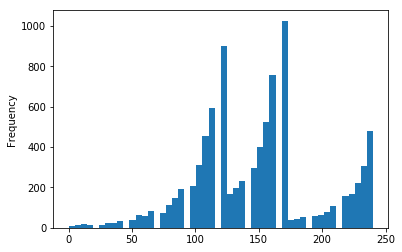

In [355]:
# distribution of resting time when a customer received an offer
(offer_viewed_no_null_3or_not_last.duration * 24 - offer_viewed_no_null_3or_not_last.t_viewed).plot("hist", bins = 50)

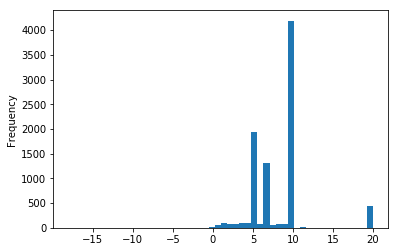

In [369]:
# distribution of resting amount when a customer received an offer
(offer_viewed_no_null_3or_not_last.difficulty - offer_viewed_no_null_3or_not_last.amt_till_viewed).plot("hist", bins = 50)

# Something is wrong about the data below.
# Even though when the BOGO is viewed, the amout reached the difficulty.

# Then looking at the transcript of "c58726d95ba8447ba01036e9d50da94c",
# I found that BOGO difficulty is not for accumulating amount.

# Discount should be accomplished by total transcript, but BOGO has to be accompolished at once....

# To be continued in notbook 190409...

In [374]:
offer_viewed_no_null_3or_not_last[(offer_viewed_no_null_3or_not_last.difficulty - offer_viewed_no_null_3or_not_last.amt_till_viewed)<0]

,person,age,income,gender_F,gender_M,gender_O,became_year,became_month_sin,became_month_cos,became_day_sin,became_day_cos,became_dow_sin,became_dow_cos,offer_bogo,offer_disc,difficulty,duration,reward,email,mobile,social,web,t_received,t_viewed,amt_till_viewed,t_completed,amt_till_completed
1289,c58726d95ba8447ba01036e9d50da94c,64.0,52000.0,0.0,1.0,0.0,2016,1.000000e+00,6.123234e-17,-3.943559e-01,0.918958,0.781831,0.623490,1,0,5,7,5,1,1,0,1,0,138.0,7.04,NaN,NaN
1436,ec24a28bab9a4548baa8a3f34800f8e1,77.0,70000.0,1.0,0.0,0.0,2018,1.224647e-16,-1.000000e+00,-8.978045e-01,-0.440394,0.433884,-0.900969,1,0,10,5,10,1,1,1,1,0,66.0,10.34,NaN,NaN
3623,26873f30a4b740e1b1831fc5e76d2fd3,52.0,32000.0,1.0,0.0,0.0,2014,5.000000e-01,-8.660254e-01,-7.907757e-01,-0.612106,0.781831,0.623490,1,0,5,7,5,1,1,0,1,0,138.0,11.75,NaN,NaN
5105,56a24501a23f4d34b70d88ab867b65e2,43.0,36000.0,1.0,0.0,0.0,2016,-5.000000e-01,8.660254e-01,-9.680771e-01,-0.250653,0.781831,0.623490,1,0,10,5,10,1,1,1,1,0,102.0,13.67,NaN,NaN
8565,e63bbd64cf5e43baa4dd9ef77c99f050,58.0,39000.0,0.0,1.0,0.0,2014,8.660254e-01,-5.000000e-01,-4.853020e-01,-0.874347,-0.433884,-0.900969,1,0,5,5,5,1,1,1,1,168,72.0,8.37,NaN,NaN
9391,fb89e4ae9fbc4a3d8f701556290ac87c,29.0,55000.0,0.0,1.0,0.0,2017,1.000000e+00,6.123234e-17,-6.513725e-01,-0.758758,-0.781831,0.623490,1,0,5,7,5,1,1,0,1,168,48.0,5.08,90.0,11.02
9415,49295418cdfb40aba2dba760b44a0a08,44.0,34000.0,1.0,0.0,0.0,2017,1.000000e+00,6.123234e-17,8.978045e-01,-0.440394,-0.433884,-0.900969,1,0,10,5,10,1,1,1,1,168,66.0,13.06,NaN,NaN
10252,40ce078d5b2a43d19138a788754520be,61.0,31000.0,0.0,1.0,0.0,2016,5.000000e-01,-8.660254e-01,3.943559e-01,0.918958,0.000000,1.000000,1,0,10,7,10,1,1,1,0,168,18.0,10.12,30.0,25.92
11193,da6918b53fd54371a5ce83b2092fd01c,45.0,55000.0,0.0,1.0,0.0,2017,-8.660254e-01,-5.000000e-01,-2.449294e-16,1.000000,0.433884,-0.900969,1,0,5,5,5,1,1,1,1,168,24.0,6.74,NaN,NaN
11461,e0780fee1ddf45f98fcc65beb58966a1,19.0,51000.0,0.0,1.0,0.0,2016,5.000000e-01,-8.660254e-01,9.987165e-01,-0.050649,-0.781831,0.623490,1,0,5,5,5,1,1,1,1,168,12.0,6.98,78.0,20.69
